<a href="https://colab.research.google.com/github/geraldoferreira1963/MVP_Analise_Dados/blob/main/MVP_1_Analise_Dados_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objetivo do trabalho **

Analisar e explorar os dois datasets os datasets listados abaixo, e verificar eventuais correlações entre os mesmos.

    (1) Emissão de CO2 na Cadeia de Produção de Alimentos (com uma discriminação das emissões em diversos pontos da Cadeia, bem como nas etapas de produção de uma cultura);
    (2) Produção de alimentos (discriminados por paises e por diversas culturas)



In [124]:
# carregando os módulos e bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
from collections import defaultdict
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline
import editdistance





# **Apresentação dos Datasets**


(I) Agri-food CO2 emission dataset - Forecasting ML ( https://www.kaggle.com/datasets/alessandrolobello/agri-food-co2-emission-dataset-forecasting-ml ) lista as emissões de CO2 relacionados relacionados com agronegócio. Os  campos abaixo estão presentes no dataset:

         (1) Savanna fires : emissão de CO2 devido a incêndios neste ecosistema;
         (2) Forest fires : emissão de CO2 devido a incêndios nas florestas;
         (3) Crop Residues : emissão de CO2 decorrente dos  resíduos durante o cultivo
         (4) Rice Cultivation: emissão decorrente da cultura de arroz;
         (5) Drained organic soils (CO2): Emissões de dióxido de carbono liberadas ao se drenar solos orgânicos;
         (6) Pesticides Manufacturing: emissão na fabricação de defensivos agricolas;
         (7) Food Transport: emissão decorrent do transporte e distribuição do alimento;
         (8) Forestland: Basicamente este campo é uma proxy considerando a área do pais coberta por florestas com a captura de CO2. Este um valor negativo (no sentido de que ele absorve CO2);
         (9)Net Forest conversion: Uma proxy que associa o desmatamento que ocorre no pais com a emissão de CO2;
         (10) Food Household Consumption: emissões decorrente do consumo de alimentos;
         (11) Food Retai : emissões nas operações de varejo;
         (12) On-farm Electricity Use: emissão de CO2 decorrente do consumo de energia nas unidades produtoras (Fazendas);
         (13) Food Packaging: Emissões da produção/ descarte das embalagens dos alimentos;
         (14) Agrifood Systems Waste Disposal : emissões devido ao descarte de alimentos;
         (15) Food Processing: Emissões decorrentes do  processamento de produtos alimentícios;
         (16) Fertilizers Manufacturing : Emissões decorrentes da  produção de defensivos agricolas;
         (17) IPPU: Emissões nos  processos industriais e no uso de produtos.
         (18) Manure applied to Soils: Emissões decorrente da utilização de esterco animal;
         (19) Manure left on Pasture : Emissões do dejeto animal em pastagens ou terras de pastagem;
         (20) Manure Management : emissões da gestão e tratamento de esterco animal;
         (21) Fires in organic soilss: Emissões decorrentes de incêndios nos solos organicos;
         (22) Fires in humid tropical forests : Emissões decorrentes dos  incêndios nas florestas tropicais;
         (23) Rural population : Número de pessoas do pais residentes  nas rurais.
         (24) Urban population : Número de pessoas residentes nas  áreas urbanas.
         (25) Total Population - Masculino: População total masculina
         (26) Total Population - Female : População total feminina
         (27) total_emission: emissão total de CO2 (somatória 1 até 22)
         (28) Average Temperature °C : Aumento médio da Temperatura

(II) Crop statistics FAO - All countries (https://www.kaggle.com/datasets/raghavramasamy/crop-statistics-fao-all-countries) dataset que tem como base os dados da FAO com relação a produção de alimento ( http://www.fao.org/faostat/en/#data/QC), dados da produção de cerca de 173 alimentos (origem vegetal)  de diversos paises, abrangendo diversas categorias de culturas.


          (1) Area: Pais;
          (2) Item: Cultura produzida;
          (3) Year: Ano ;
          (4) Value: Quantidade (em Toneladas) do alimento

In [125]:
url_1 = 'https://raw.githubusercontent.com/geraldoferreira1963/MVP_Analise_Dados/main/Agrofood_co2_emission.csv'
url_2 ='https://raw.githubusercontent.com/geraldoferreira1963/MVP_Analise_Dados/main/Crop.csv'

response_1 = requests.get(url_1)
response_2 = requests.get(url_2)


file_content_1 = response_1.text
file_1 = StringIO(file_content_1)

file_content_2 = response_2.text
file_2 = StringIO(file_content_2)


df_alimentos_emissao_co2=pd.read_csv(file_1)
df_producao_alimentos=pd.read_csv(file_2, delimiter=';')



#                  # **Definição de Funções**

(1) Classificar a cultura : recebe uma string com um nome de uma plantação, e classifica a mesma de acordo com um dicionário de culturas previamente definido. A definição da categoria não segue rigorosamente as categorias da área.

(2) Recebe dois dataframes tendo uma coluna com o nome de um país, e a função verifica as diferenças entre as duas colunas (cada uma em um dataframe).

(3) função para formatar plotagem

(4) Função para formatar uma análise de covariance usando Heatmap

In [161]:
def classificacao_cultura (cultura) :
  Dicionario_cultura=defaultdict(lambda : "Não encontrado")
  Dicionario_culturas = {
    "Frutas":               ["Apples", "Apricots", "Berries nes", "Figs", "Fruit, citrus nes", "Fruit, fresh nes", "Fruit, stone nes", "Grapes", "Melons, other (inc.cantaloupes)",
                             "Oranges", "Peaches and nectarines", "Pears", "Plums and sloes", "Watermelons", "Citrus Fruit, Total", "Fruit Primary", "Fruit, tropical fresh nes",
                             "Grapefruit (inc. pomelos)", "Lemons and limes", "Mangoes, mangosteens, guavas", "Papayas", "Pineapples", "Strawberries",
                             "Tangerines, mandarins, clementines, satsumas", "Bananas", "Dates", "Kiwi fruit", "Persimmons", "Raspberries", "Blueberries", "Currants", "Gooseberries",
                             "Cranberries", "Cashewapple","Avocados", "Quinces", "Plantains and others", "Fruit, pome nes", "Carobs"],
    "Vegetais":             ["Onions, dry", "Potatoes", "Vegetables, fresh nes", "Vegetables Primary", "Beans, dry", "Beans, green", "Broad beans, horse beans, dry",
                             "Cabbages and other brassicas","Carrots and turnips", "Cauliflowers and broccoli", "Cherries", "Cherries, sour", "Chillies and peppers, green",
                             "Cucumbers and gherkins", "Eggplants (aubergines)", "Garlic", "Leeks, other alliaceous vegetables", "Lettuce and chicory", "Mushrooms and truffles",
                             "Okra", "Onions, shallots, green", "Peas, green", "Pumpkins, squash and gourds", "Spinach", "Tomatoes", "Vegetables, leguminous nes", "Vetches",
                             "Artichokes", "Asparagus", "Chick peas", "Lentils", "Peas, dry", "String beans", "Cow peas, dry", "Lupins", "Chicory roots","Maize, green",
                             "Pigeon peas", "Rubber, natural"],
    "Nozes e Sementes":      ["Almonds, with shell", "Nuts nes", "Olives", "Pistachios", "Walnuts, with shell", "Chestnut", "Groundnuts, with shell", "Hazelnuts, with shell",
                              "Treenuts, Total", "Cashew nuts, with shell", "Areca nuts", "Brazil nuts, with shell", "Karite nuts (sheanuts)", "Kola nuts", "Tung nuts",
                              "Coconuts", "Melonseed", "Pepper (piper spp.)", "Nutmeg, mace and cardamoms", "Poppy seed", "Mustard seed", "Safflower seed", "Sesame seed",
                              "Sunflower seed", "Linseed", "Castor oil seed", "Hempseed", "Jojoba seed", "Tallowtree seed","Oilcrops", "Oilcrops, Cake Equivalent",
                              "Oilcrops, Oil Equivalent", "Rapeseed", "Oil palm fruit", "Oilseeds nes", "Seed cotton", "Fibre Crops Primary", "Bastfibres, other",
                              "Flax fibre and tow", "Sisal", "Fibre crops nes", "Hemp tow waste", "Coir", "Jute", "Agave fibres nes", "Manila fibre (abaca)", "Kapok fruit", "Ramie"],
    "Cereais e Leguminosas": ["Barley", "Maize", "Millet", "Rice, paddy", "Rice, paddy (rice milled equivalent)", "Wheat", "Cereals, Total", "Pulses nes", "Pulses, Total",
                              "Oats", "Rye", "Sorghum", "Soybeans", "Triticale", "Buckwheat", "Canary seed", "Cereals nes", "Fonio", "Grain, mixed", "Quinoa", "Bambara beans",
                              "Maté", "Peppermint", "Tea","Cocoa, beans", "Coffee, green", "Hops", "Tobacco, unmanufactured", "Sugar beet", "Sugar cane", "Sugar crops nes",
                              "Roots and Tubers, Total", "Sweet potatoes", "Taro (cocoyam)", "Yams", "Yautia (cocoyam)", "Cassava", "Cassava leaves", "Roots and tubers nes",
                              "Anise, badian, fennel, coriander", "Spices nes", "Chillies and peppers, dry", "Ginger", "Vanilla", "Cinnamon (cannella)", "Cloves",
                              "Pyrethrum, dried", "Sugar Crops Primary"]
                          }

  for categoria, plantacao in Dicionario_culturas.items():
    if cultura in plantacao:
      return categoria
  return "Não encontrado"

# função recebe dois dataframes, onde existe uma coluna representando paises, gera duas listas com as diferenças (entre DF_1 e DF_2, e entre DF_2 e DF_1) de nomes de paises encontrados. Após isto, a função tenta verificar alguma
# similaridade entre as duas listas a fim de verificar um mesmo pais escrito de formas diferentes entre os dataframes. A função recebe além dos dois dataframes, os nomes das colunas (em cada dataframe) onde são listados os paises,
# retorna as diferenças, duas listas com sugestões de remoção de paises - não encontrados no outro dataframe.

def analisar_diferenca_paises (df_1, coluna_pais_df_1,df_2,coluna_pais_df_2):
  lista_paises_df_1 = df_1[coluna_pais_df_1].unique()
  lista_paises_df_2 = df_2[coluna_pais_df_2].unique()
  diferenca_df_1Xdf_2= np.setdiff1d(lista_paises_df_1, lista_paises_df_2)
  diferenca_df_2Xdf_1 = np.setdiff1d(lista_paises_df_2, lista_paises_df_1)
  threshold = 2
  lista_correcao = []
  remover_df_1 = []
  remover_df_2 = []
  for pais_1 in diferenca_df_1Xdf_2:
        similar = False
        for pais_2 in diferenca_df_2Xdf_1:
            distancia = editdistance.eval(pais_1, pais_2)
            if distancia <= threshold:
                similar = True
                lista_correcao.append((pais_1, pais_2, distancia))
        if similar == False:
            remover_df_1.append(pais_1)
  for pais_2 in diferenca_df_2Xdf_1:
        if pais_2 not in lista_correcao:
          remover_df_2.append(pais_2)
  return (diferenca_df_1Xdf_2, diferenca_df_2Xdf_1,lista_correcao,remover_df_1,remover_df_2)

# função tem como objetivo formatar um gráfico de heatmap, recebe um dataframe, campos a serem plotados e uma lista de paises

def formatacao(x):
  if isinstance(x, float):
    return '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.')
  else:
      return x

def formatar_plotagem (df,ano,pais,titulo, paleta,i,j,campos=None) :
    ax[i,j].plot(df[ano].unique(),df[df.Area == pais].loc[:,[campos]], label=paleta)
    ax[i,j].set_title(titulo)
    ax[i,j].legend(paleta)
    ax[i,j].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: formatacao(x)))
    ax[i,j].set_ylabel('Total de Emissão (ton/CO2)')




def grafico_heatmap (df, campos,lista_paises):
    fig, ax = plt.subplots(3,2, figsize = (20, 15))
    sns.set(font_scale=1.0)
    i=j=0
    for pais in lista_paises:
      sns.heatmap(df[df.Area == pais].loc[:,campos + ['total_emission']].corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1,fmt="1.2f",ax=ax[i,j],annot_kws={"size": 8 })
      ax[i,j].set_title(pais)
      ax[i,j].tick_params(axis='both', which='major', labelsize=7)
      j+=1
      if j == 2:
        i+=1
        j=0
    plt.show()
    return()


# Verificação inicial dos datasets, suas colunas, características.

In [127]:
print('Campos do Dataset de Emissão CO2 - Produção de Alimento')
print('\n',"numero de registros X colunas = ", df_alimentos_emissao_co2.shape)
print('\n\n\n',df_alimentos_emissao_co2.info())


print('\n\n\n\n\n\n','Campos do Dataset de Produção de Grãos')
print('\n\n\n',"numero de registros X colunas = ",df_producao_alimentos.shape)
print('\n\n\n',df_producao_alimentos.info())

print('\n\n\n', 'Valores NA - Emissão de CO2', df_alimentos_emissao_co2.isna().sum())

print('\n\n\n', 'Valores NA - Produção de Alimentos',df_producao_alimentos.isna().sum())





Campos do Dataset de Emissão CO2 - Produção de Alimento

 numero de registros X colunas =  (6965, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Area                             6965 non-null   object 
 1   Year                             6965 non-null   int64  
 2   Savanna fires                    6934 non-null   float64
 3   Forest fires                     6872 non-null   float64
 4   Crop Residues                    5576 non-null   float64
 5   Rice Cultivation                 6965 non-null   float64
 6   Drained organic soils (CO2)      6965 non-null   float64
 7   Pesticides Manufacturing         6965 non-null   float64
 8   Food Transport                   6965 non-null   float64
 9   Forestland                       6472 non-null   float64
 10  Net Forest conversion            6472 non-

# Ajustes no dataset de Produção de Alimentos

(1) Valores NA da Produção de Alimentos serão zerados.

(2) Na sequencia haverá a criação de uma coluna adicional "Cultura", a qual terá categorização do alimento (Item) em um dos tipos de Culturas definidos no trabalho.


In [128]:
df_producao_alimentos.fillna(0, inplace=True)

# Classificar as diversas culturas nas categorias estabelecidas no trabalho, e uma coluna adicional será criada a fim de armazenar a informação

df_producao_alimentos['Cultura']=df_producao_alimentos['Item'].apply(classificacao_cultura)

df_producao_alimentos.head(5)

,Unnamed: 0,Area,Item,Year,Value,Cultura
0,19,Afghanistan,"Almonds, with shell",1994,9000.0,Nozes e Sementes
1,20,Afghanistan,"Almonds, with shell",1995,9000.0,Nozes e Sementes
2,21,Afghanistan,"Almonds, with shell",1996,9000.0,Nozes e Sementes
3,22,Afghanistan,"Almonds, with shell",1997,9000.0,Nozes e Sementes
4,23,Afghanistan,"Almonds, with shell",1998,9000.0,Nozes e Sementes


In [129]:
df_producao_alimentos.isnull().sum()

,0
Unnamed: 0,0
Area,0
Item,0
Year,0
Value,0
Cultura,0


# Retirada das emissões decorrentes dos alimentos de origem animal

A  tabela de produção de alimentos não contempla os de origem animal, e no dataset de emissão de CO2 na Produção de Alimentos existem dados referentes aos mesmos, assim os seguintes ajustes serão feitos


              (1) Ajuste do campo "total_emission" retirando as emissões referentes a criação de animais(colunas 'Manure left on Pasture' e 'Manure Management').
              
              (2) A coluna de "Manure applied to Soils" será mantida

              (3) Removida as colunas mencionadas no item (1) acima do dataframe de emissão de CO2
  
  Existem campos NA no dataset de Emissão de CO2 no entanto, a decisão será por manter os mesmos.

In [130]:
# remoção da emissão total emissões relacionados com a criação de animais
df_alimentos_emissao_co2[['Manure left on Pasture', 'Manure Management']]=df_alimentos_emissao_co2[['Manure left on Pasture', 'Manure Management']].fillna(0)
df_alimentos_emissao_co2['total_emission']= df_alimentos_emissao_co2['total_emission'] -  df_alimentos_emissao_co2['Manure left on Pasture'] - df_alimentos_emissao_co2['Manure Management']
df_alimentos_emissao_co2.drop(columns=['Manure left on Pasture', 'Manure Management'], inplace=True)
df_alimentos_emissao_co2.columns



Index(['Area', 'Year', 'Savanna fires', 'Forest fires', 'Crop Residues',
       'Rice Cultivation', 'Drained organic soils (CO2)',
       'Pesticides Manufacturing', 'Food Transport', 'Forestland',
       'Net Forest conversion', 'Food Household Consumption', 'Food Retail',
       'On-farm Electricity Use', 'Food Packaging',
       'Agrifood Systems Waste Disposal', 'Food Processing',
       'Fertilizers Manufacturing', 'IPPU', 'Manure applied to Soils',
       'Fires in organic soils', 'Fires in humid tropical forests',
       'On-farm energy use', 'Rural population', 'Urban population',
       'Total Population - Male', 'Total Population - Female',
       'total_emission', 'Average Temperature °C'],
      dtype='object')

# Preparação para o Merge dos datasets

As seguintes atividades serão realizadas

    (1) O dataset de produção de alimentos será pivotado é um novo dataframe criado DF_PRODUCAO_GRAO;
    (2) Verificar paises listados em um dataframe e não no outro. A lista dos paises será inspecionada, e ajuste tomarão lugar.  

In [131]:
# pivotando a tabela df_producao_grao, sumrizando os dados de produção em função dos tipos de Culturas definidos.

df_producao_grao= df_producao_alimentos.pivot_table(index=['Area', 'Year'], columns=['Cultura'],
                                                    values='Value',fill_value = 0).reset_index()
print('\n\n\n\n\n', 'Tabela de Produção de Alimentos ')
print(df_producao_grao.head(5))


# função para analisar os nomes de paises empregados nos dois dataframes, e listar as diferenças para a padronização
# (1) Acionar função a fim de gerar uma lista dos paises dos datasets de emissão de co2 e produção alimentos, verificar as diferenças existentes entre as duas tabelas, e ajustar os nomes de paises. Os seguintes ajustes serão
#     realizados com relação a paises
#           (i) 'China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland' em ambos os datasets os valores estão consolidados em 'China'.
#           (ii) Regiões economicas, geográficas, ou continentes não serão considerados na análise
#           (iii) Territórios, ou pequenos países não serão considerados na análise
#
diferenca_emissaoXproducao, diferenca_producaoXemissao,lista_correcao,remocao_df_1,remocao_df_2 = analisar_diferenca_paises(df_alimentos_emissao_co2,'Area',df_producao_grao,'Area')
print('\n\n\n\n', 'Diferenças entre Emissão de CO2 e Produção de alimentos')
print('\n\n',diferenca_emissaoXproducao)
print('\n\n','Diferenças entre produção de Alimentos e Emissão de CO2')
print('\n\n',diferenca_producaoXemissao)






 Tabela de Produção de Alimentos 
Cultura         Area  Year  Cereais e Leguminosas       Frutas  \
0        Afghanistan  1994          493932.500000   98725.0000   
1        Afghanistan  1995          511106.285714   99775.6875   
2        Afghanistan  1996          511129.285714  101652.1250   
3        Afghanistan  1997          574839.000000  103656.8750   
4        Afghanistan  1998          604665.571429  106040.8750   

Cultura  Nozes e Sementes  Vegetais  
0            25985.500000  636648.5  
1            24818.714286  643741.5  
2            24540.571429  640834.0  
3            24642.000000  637927.0  
4            24738.642857  634519.5  




 Diferenças entre Emissão de CO2 e Produção de alimentos


 ['American Samoa' 'Andorra' 'Anguilla' 'Aruba' 'Bermuda'
 'British Virgin Islands' 'Cayman Islands' 'Channel Islands'
 'Czechoslovakia' 'Ethiopia PDR' 'Falkland Islands (Malvinas)' 'Gibraltar'
 'Greenland' 'Guam' 'Holy See' 'Isle of Man' 'Liechtenstein' 'Mayotte'
 'Monaco

    (3) remoção de paises dos datasets onde não existe correspondente na outra tabela, bem como removendo regiões economicas ou continentes.
    (4) Padronização do nome da  Holanda

In [132]:
# implementar ajustes conforme descritos acima
remover_regioes_producao = ('Africa', 'Americas', 'Asia', 'Australia and New Zealand','Caribbean', 'Central America', 'Central Asia', "Côte d'Ivoire",'Eastern Africa', 'Eastern Asia', 'Eastern Europe', 'Europe',
                        'European Union (27)', 'European Union (28)', 'French Guyana','Land Locked Developing Countries', 'Least Developed Countries', 'Low Income Food Deficit Countries', 'Melanesia',
                        'Micronesia', 'Middle Africa', 'Net Food Importing Developing Countries', 'Northern Africa', 'Northern America','Northern Europe', 'Oceania', 'Polynesia', 'Réunion',
                        'Small Island Developing States', 'South America', 'South-eastern Asia', 'Southern Africa', 'Southern Asia', 'Southern Europe', 'Turkey', 'Western Africa', 'Western Asia',
                        'Western Europe','World', 'China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland')

remover_regioes_emissao = ('American Samoa', 'Andorra', 'Anguilla', 'Aruba', 'Bermuda','British Virgin Islands', 'Cayman Islands', 'Channel Islands', 'Falkland Islands (Malvinas)', 'Gibraltar', 'Greenland', 'Guam',
                       'Holy See', 'Isle of Man', 'Liechtenstein', 'Mayotte', 'Monaco', 'Montserrat', 'Netherlands Antilles (former)', 'Northern Mariana Islands','Palau', 'Saint Helena, Ascension and Tristan da Cunha',
                       'Saint Pierre and Miquelon', 'San Marino', 'Turks and Caicos Islands', 'United States Virgin Islands', 'Wallis and Futuna Islands', 'Western Sahara','Czechoslovakia', 'Ethiopia PDR',
                        'Pacific Islands Trust Territory', 'USSR', 'Yugoslav SFR', 'China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland')

df_alimentos_emissao_co2 = df_alimentos_emissao_co2[~df_alimentos_emissao_co2['Area'].isin(remover_regioes_emissao)]
df_producao_grao = df_producao_grao[~df_producao_grao['Area'].isin(remover_regioes_producao)]

# padronizar nome da Holanda

padronizar_nomes_paises_de=['Netherlands (Kingdom of the)']
padronizar_nomes_paises_para=['Netherlands']
df_alimentos_emissao_co2=df_alimentos_emissao_co2.replace(padronizar_nomes_paises_de,padronizar_nomes_paises_para)

In [133]:
# nova verificação após os ajustes

diferenca_emissaoXproducao, diferenca_producaoXemissao,lista_correcao,remocao_df_1,remocao_df_2 = analisar_diferenca_paises(df_alimentos_emissao_co2,'Area',df_producao_grao,'Area')

print('diferenças entre Emissão de Co2  e Produção de alimentos')
print('\n\n',diferenca_emissaoXproducao)
print('\n\n','diferenças entre Produção de Alimentos e Emissão de CO2')
print('\n\n',diferenca_producaoXemissao)


diferenças entre Emissão de Co2  e Produção de alimentos


 []


 diferenças entre Produção de Alimentos e Emissão de CO2


 []


      (5) definir um periodo de tempo para as análises que seja coerente com os dados existentes em ambos os datasets. Definido periodo entre 1994 - 2019

In [134]:
# estabelecer periodo de tempo da análise, iniciando por verificar o periodo disponível de dados em cada uma dos datasets

print('periodo de tempo máximo e minimo da Produção de Grãos =>',df_producao_grao['Year'].max(), df_producao_grao['Year'].min())
print('periodo de tempo máximo e minimo da Emissão de CO2 =>',df_alimentos_emissao_co2['Year'].max(), df_alimentos_emissao_co2['Year'].min())

periodo de tempo máximo e minimo da Produção de Grãos => 2019 1994
periodo de tempo máximo e minimo da Emissão de CO2 => 2020 1990


In [135]:
# estabelecendo um periodo de tempo para análise dos datasets, selecionado o periodo (1994 - 2019) para a análise dos dados
df_co2_1= df_alimentos_emissao_co2[(df_alimentos_emissao_co2.Year >= 1994) & (df_alimentos_emissao_co2.Year < 2019)]
df_grao_1=df_producao_grao[df_producao_grao.Year >= 1994]
# df_energia_1=df_energia_renovavel_1[df_energia_renovavel_1.Year >= 2000]

    (6) Crir uma coluna adicional no dataset de Produção de Alimentos sumarizando o total (em toneladas) de Alimentos produzidos

In [136]:
# totalizar a produção de Alimentos do dataset de Produção
excluir = ['Area', 'Year']
df_grao_1['Total']=df_grao_1.drop(columns=excluir).sum(axis=1)


Merge dos datasets

In [137]:
# criar um novo dataset resultante da consolidação dos dois datasets anteriores

colunas_merger = ('Area', 'Year')

df=pd.merge(left=df_co2_1,right=df_grao_1,on=colunas_merger)




# Campos adicionais  :

Serão criados campos adicionais agrupando dados da emissão em  diversas etapas da Produção dos Alimentos:

    (i) Coluna *fontes_emissão_co2_cultivo* : agrupará  informações das emissões de CO2 decorrente de "práticas" ou atividades realizadas durante a etapa de plantio do alimento
    (ii) Coluna *emissão_co2_cadeia_processamento_comida* : agrupará dados das emissões na produção do alimento, e na produção da embalagem para o mesmo





In [138]:
# fontes_emissão_co2_cultivo :agrupando os atributos referentes ao processo de cultivo dos alimentos.

emissao_co2_cultivo = [ 'Crop Residues','Drained organic soils (CO2)','Agrifood Systems Waste Disposal', 'Fires in organic soils','Manure applied to Soils']

# emissão_co2_cadeia_processamento_comida : agrupará dados da emissão de CO2 na Cadeia de Processamento dos Alimentos. Basicamente no processamento do Alimentos, e Embalagem
# fonte : https://www.fertisystem.com.br/m/blog/60d384532ab2c055dc7e9716/quais-sao-as-etapas-das-cadeias-produtivas-do-agronegocio-entenda#:~:text=Distribui%C3%A7%C3%A3o,e%20supermercados%2C%20por%20exemplo).

emissao_co2_cadeia_processamento_comida = ['Food Processing', 'Food Packaging']

# incendios : Os dados de emissão de CO2 decorrentes de incêndios no Biomas

incendios=['Savanna fires', 'Forest fires','Fires in humid tropical forests']

# fontes de emissão de CO2 referentes aos atributos que fazem parte do fornecimento de insumos

emissao_co2_fornecimento_insumos = [ 'Pesticides Manufacturing','Fertilizers Manufacturing' ]

# criando campos adicionais no dataset consolidados agrupandos a totalização das emissões nas visões previamente definidas

df['soma_emissao_co2_cultivo'] = df[emissao_co2_cultivo].sum(axis=1)
df['soma_emissao_co2_incendio']=df[incendios].sum(axis=1)
df['soma_emissao_co2_cadeia_processamento']=df[emissao_co2_cadeia_processamento_comida].sum(axis=1)
df['soma_emissao_co2_fornecimento_insumos']=df[emissao_co2_fornecimento_insumos].sum(axis=1)




 Análises Iniciais


 Os 10 maiores paises emissores de CO2 no periodo 1994 - 2019 : ['China', 'Brazil', 'Indonesia', 'United States of America', 'India', 'Democratic Republic of the Congo', 'Canada', 'Japan', 'Mexico', 'Germany']


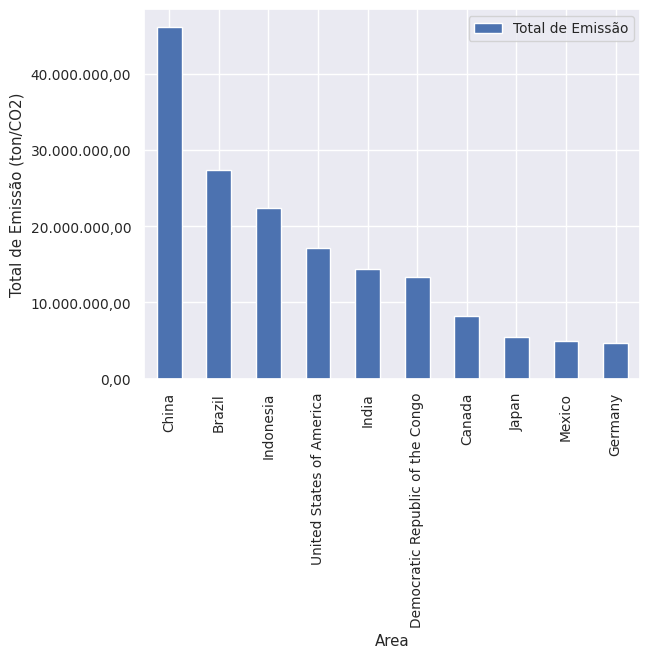



 Os 10 maiores produtores de alimentos no periodo 1994 - 2019 :  ['China', 'Brazil', 'Indonesia', 'United States of America', 'India', 'Democratic Republic of the Congo', 'Canada', 'Japan', 'Mexico', 'Germany']


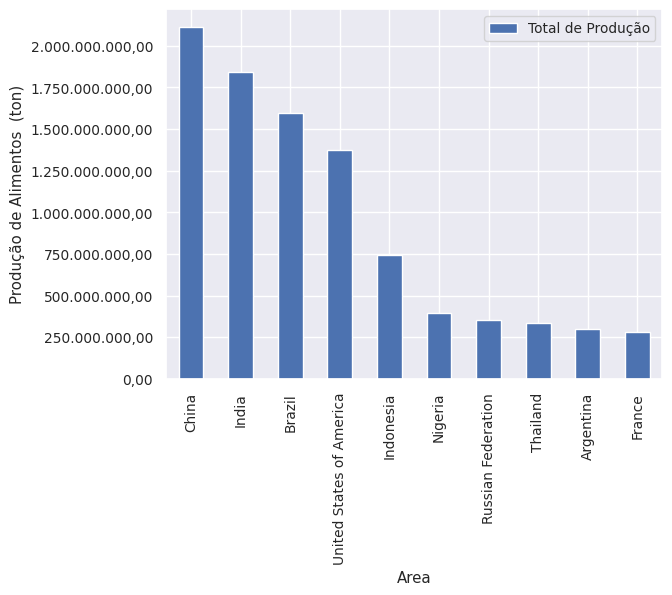

In [155]:
# Análise Inicial das Emissões
# (1) Os 10 maiores paises emissores de CO2 no periodo, e o total das suas emissões no periodo de análise

df_maiores_emissores = df.groupby('Area')['total_emission'].sum().reset_index().sort_values(by='total_emission', ascending=False).head(10)
maiores_emissores =list(df_maiores_emissores['Area'].unique())

print('\n\n', 'Análises Iniciais')
print('\n\n', 'Os 10 maiores paises emissores de CO2 no periodo 1994 - 2019 :', maiores_emissores)

ax = df_maiores_emissores.plot.bar(x='Area', y='total_emission',label='Total de Emissão');

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: formatacao(x)))
ax.set_ylabel('Total de Emissão (ton/CO2)')

plt.show()



# (2) Os 10 maiores paises produtores de Alimentos, e o total da produção de alimentos no periodo de análise

df_maiores_produtores = df.groupby('Area')['Total'].sum().reset_index().sort_values(by='Total', ascending=False).head(10)
maiores_produtores =list(df_maiores_emissores['Area'].unique())
print('\n\n', 'Os 10 maiores produtores de alimentos no periodo 1994 - 2019 : ', maiores_produtores)

ax = df_maiores_produtores.plot.bar(x='Area', y='Total',label='Total de Produção');
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: formatacao(x)))
ax.set_ylabel('Produção de Alimentos  (ton)')

plt.show()

# **Análise**

    (i) As análises focam nos 5 maiores produtores de alimento (China, India, Brazil, Indonesia e Estados Unidos);
    (ii) objetivo é além de explorar as principais fontes de emissão de CO2 na Cadeia de Produção de Alimentos do pais, possíveis correlações entre as categorias de alimentos produzidos e a emissão de CO2;
    (iii) As análises verificam além do Total da emissão de Co2/ano no periodo, um  Detalhamento das emissões dentro da Cadeia de Produção de Alimentos, bem como de práticas no cultivo :
     (a) Produção de Fertilizantes
     (b) Produção de Defensivos Agricolas
     (c) Práticas de Cultivo
     (d) Processamento dos Alimentos
     (e) Transporte e Distribuição dos Alimentos
     (iv) Emissões de CO2 decorrentes de incêndios nos Biomas do Pais
     (v) Emissões de CO2 decorrentes de Desmatamento
     (vi) Finalmente, a absorção de CO2 decorrente da cobertura florestal do pais

Obs : Definida uma paleta de cores com o objetivo de identificar os paises, e no caso dos incêndios uma identificação do Bioma afetado



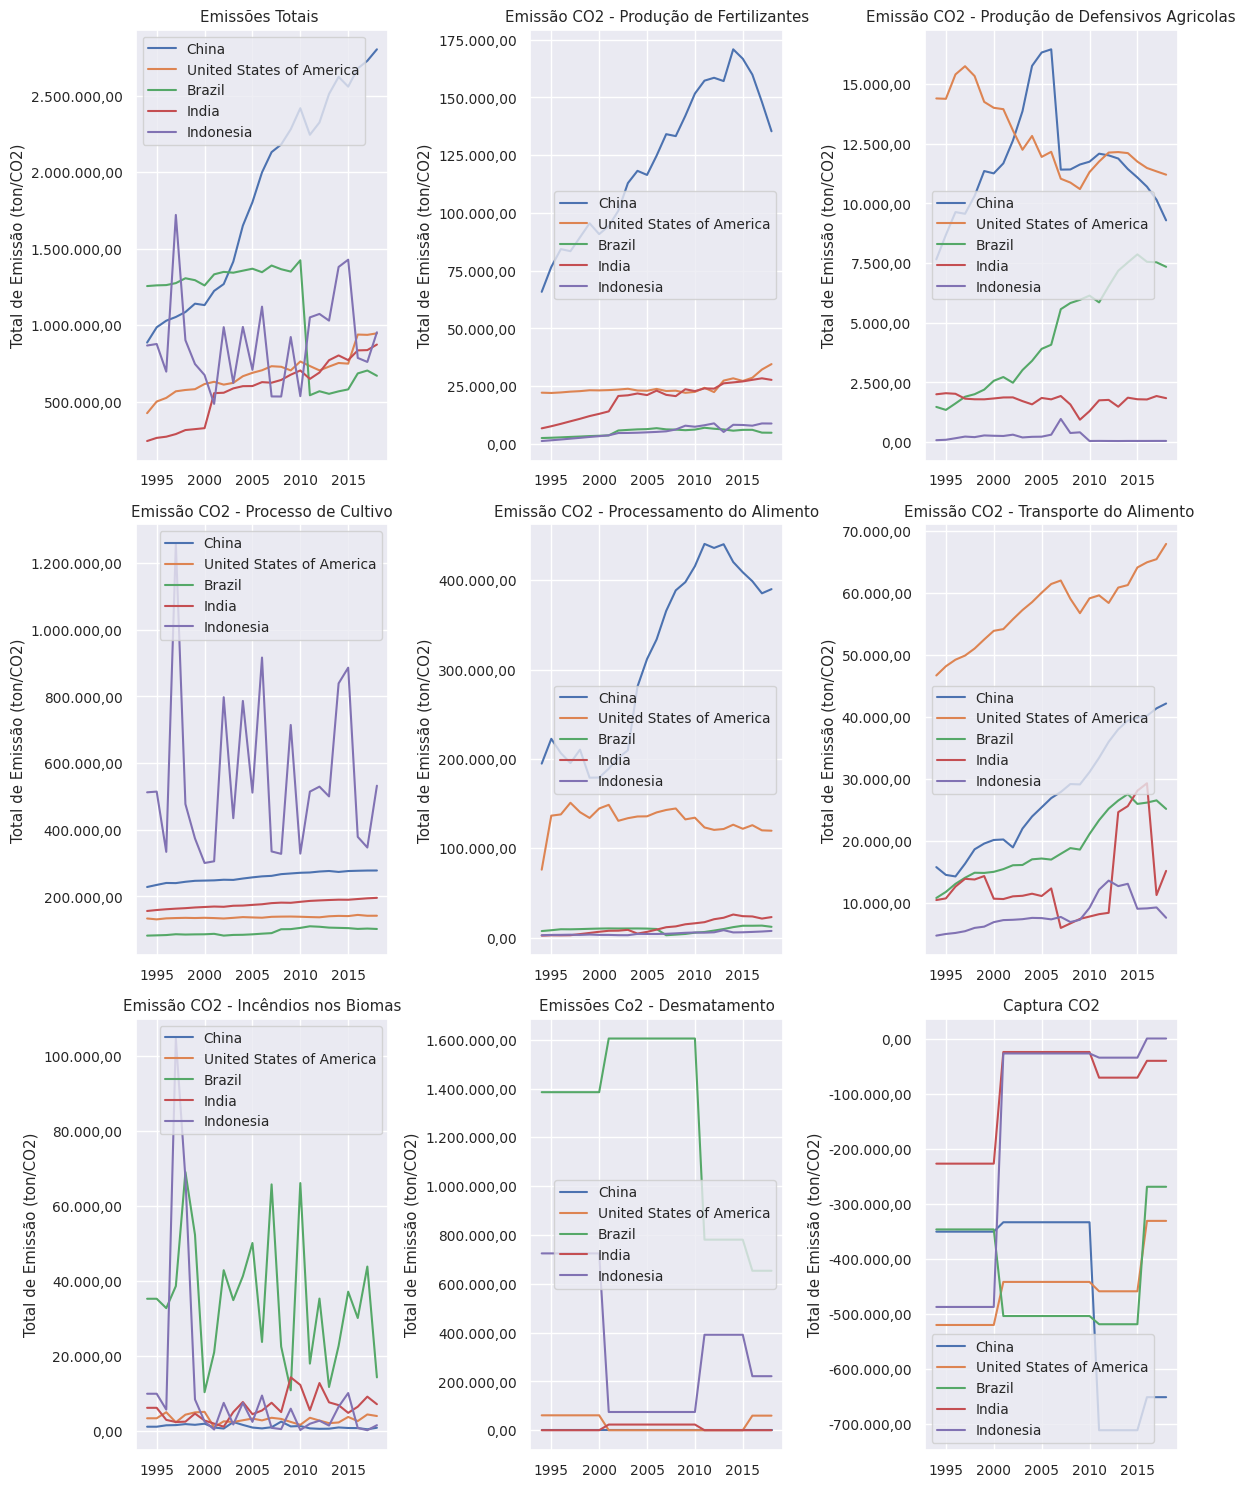

In [162]:
maiores_produtores = ['China', 'United States of America','Brazil', 'India','Indonesia']

fig, ax = plt.subplots(3,3, figsize = (12, 15))
cores_incendios={'Savanna fires':'r', 'Forest fires':'b','Fires in humid tropical forests':'gray'}
cores_paises_produtores = { 'China': '#E69F00',  # Orange
                           'United States of America': '#56B4E9',  # Sky Blue
                           'Brazil': '#009E73',  # Bluish Green
                           'India': '#F0E442',  # Yellow
                           'Indonesia': '#0072B2',  # Blue
                           }

for pais in maiores_produtores:
    formatar_plotagem (df,'Year',pais,'Emissões Totais ', cores_paises_produtores,0,0,'total_emission')
    formatar_plotagem (df,'Year',pais,'Emissão CO2 - Produção de Fertilizantes', cores_paises_produtores,0,1,'Fertilizers Manufacturing')
    formatar_plotagem (df,'Year',pais,'Emissão CO2 - Produção de Defensivos Agricolas', cores_paises_produtores,0,2,'Pesticides Manufacturing')
    formatar_plotagem (df,'Year',pais,'Emissão CO2 - Processo de Cultivo', cores_paises_produtores,1,0,'soma_emissao_co2_cultivo')
    formatar_plotagem (df,'Year',pais,'Emissão CO2 - Processamento do Alimento', cores_paises_produtores,1,1,'soma_emissao_co2_cadeia_processamento')
    formatar_plotagem (df,'Year',pais,'Emissão CO2 - Transporte do Alimento ', cores_paises_produtores,1,2,'Food Transport')
    formatar_plotagem (df,'Year',pais,'Emissão CO2 - Incêndios nos Biomas', cores_paises_produtores,2,0,'soma_emissao_co2_incendio')
    formatar_plotagem (df,'Year',pais,'Emissões Co2 - Desmatamento', cores_paises_produtores,2,1,'Net Forest conversion')
    formatar_plotagem (df,'Year',pais,'Captura CO2', cores_paises_produtores,2,2,'Forestland')

plt.tight_layout()
plt.show()



# Primeira Análise dos Dados

O primeiro conjunto de gráficos permitem algumas observações:


    (1) China apresenta a maior nível de emissão de CO2, seguido - nos últimos tempos - pela Indonésia, Estados Unidos, India e Brasil;
    
    (2) Na produção de Fertilizantes, de  Defensivos Agricolas, e durante o  Processamento dos Alimentos  China e Estados Unidos dominam as emissões nestas etapas da cadeia de alimentos, de certa forma é uma decorrência do nível de industrialização  destes países. No Brasil se observa um aumento da emissão de CO2 nesta etapa da Cadeia de Produção de Alimentos;
    
    (3) No processo de cultivo [emissões decorrente dos  resíduos durante o cultivo, de incêndios nos solos organicos, drenagem de solos organicos - retirar o excesso de água e sais do solo, a fim de melhorar as condições de aeração, estruturação e resistência -  e a utilização de esterco animal], onde se considerou como práticas de cultivo, o Brasil tem a menor emissão e a Indonésia apresenta uma emissão destacada.
    
    (4) As emissões decorrentes de incêndios nos Biomas, e no  decorrente do desmatamento,  o Brasil apresenta, em especial neste último, um forte componente emissor.

## Primeira Grupo de Análise (Correlação)

Um primeiro conjunto de análise de correlação foca em verificar possíveis relacionamentos entre a emissão dos principais paises produtores de alimentos com algumas fontes de emissão, e neste sentido as seguintes são conduzidas (utilizando a função para formatar os gráficos)

    (1) Das diversas fontes de emissão de CO2 que ocorrem durante o cultivo, e a emissão total
    
    (2) Incendios Florestas ou no Biomas e a emissão total
    
    (3) Desmatamento e a emissão de CO2


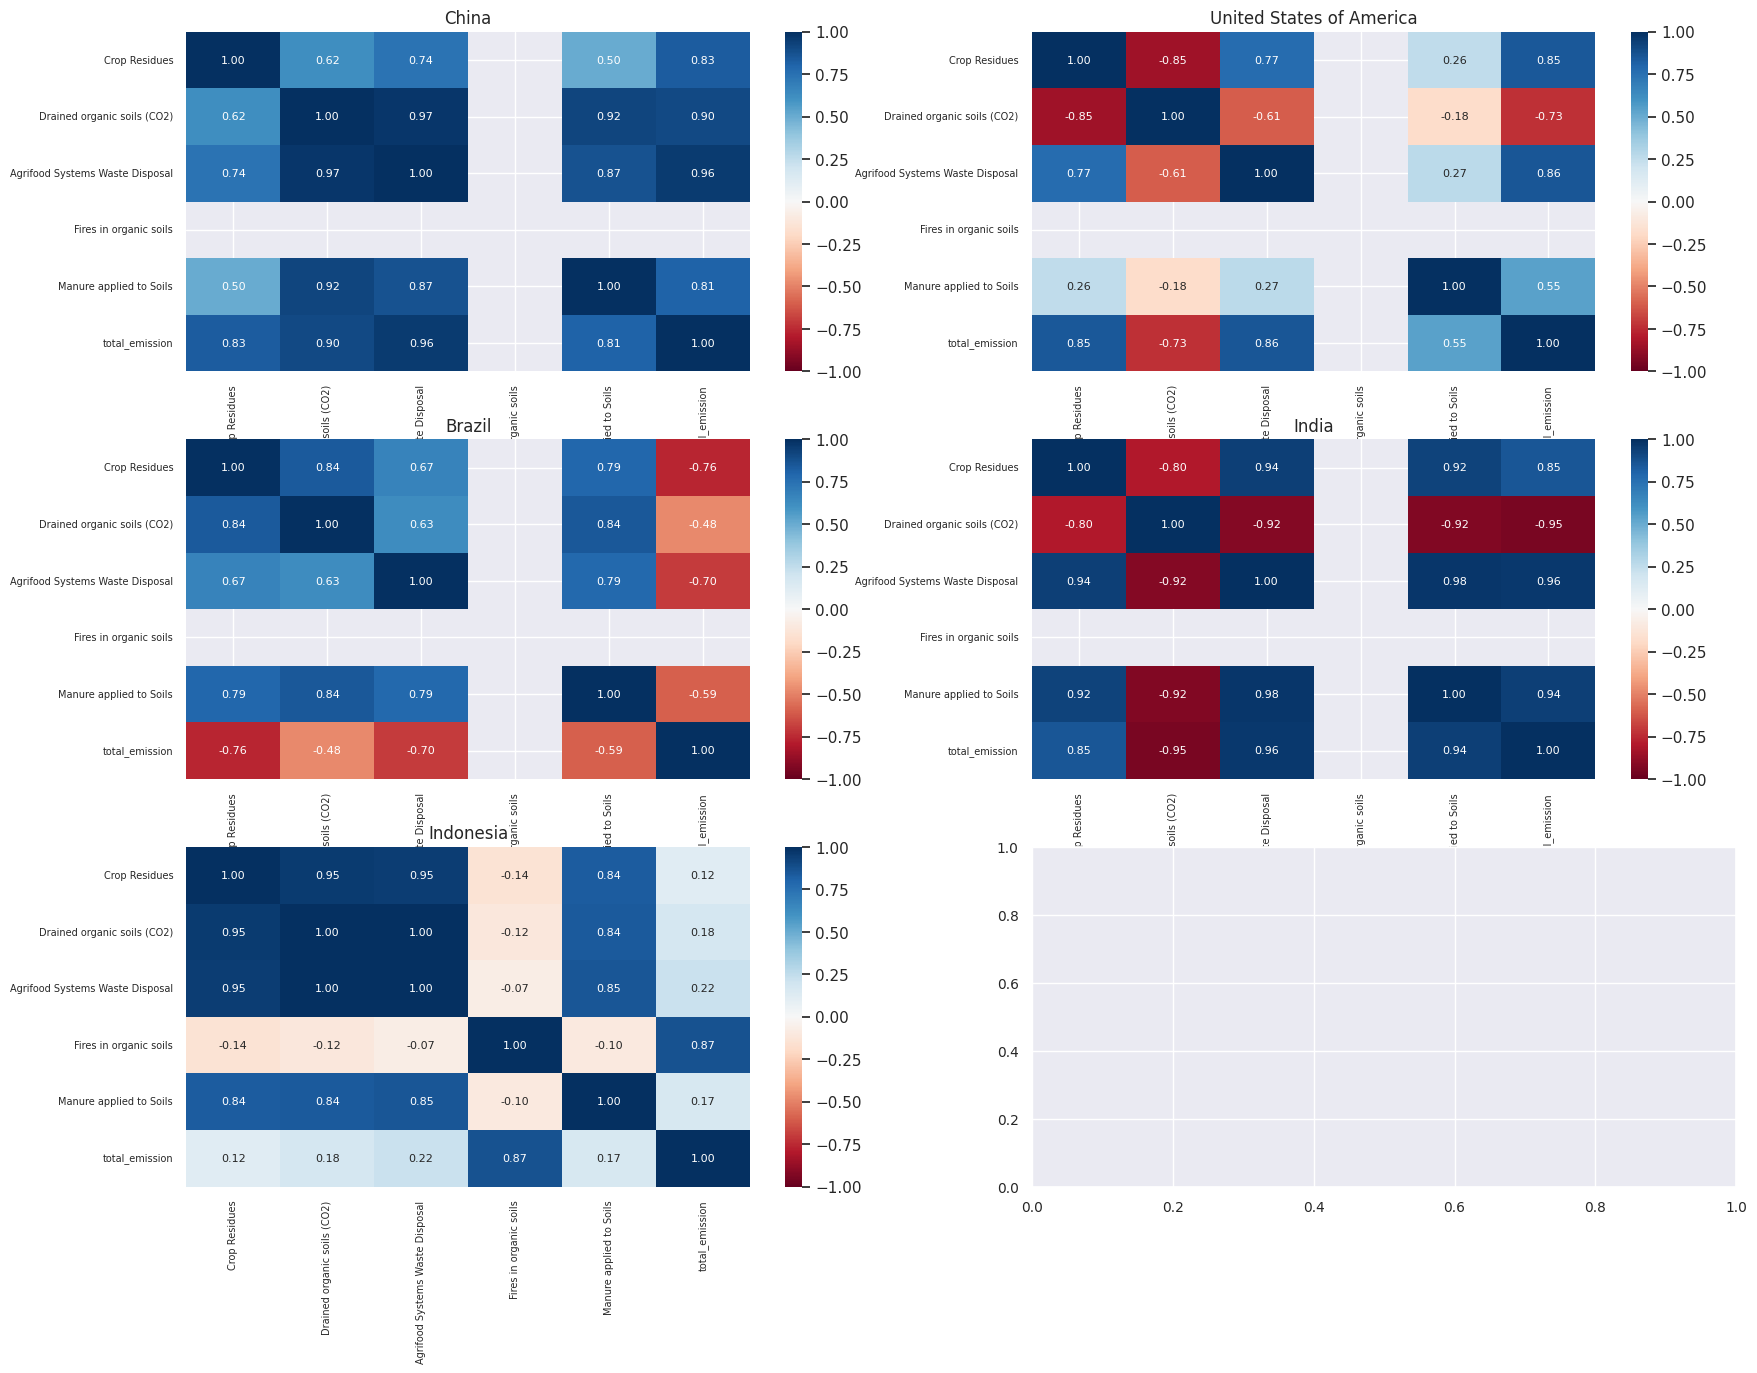

()

In [141]:

grafico_heatmap(df,emissao_co2_cultivo ,maiores_produtores)



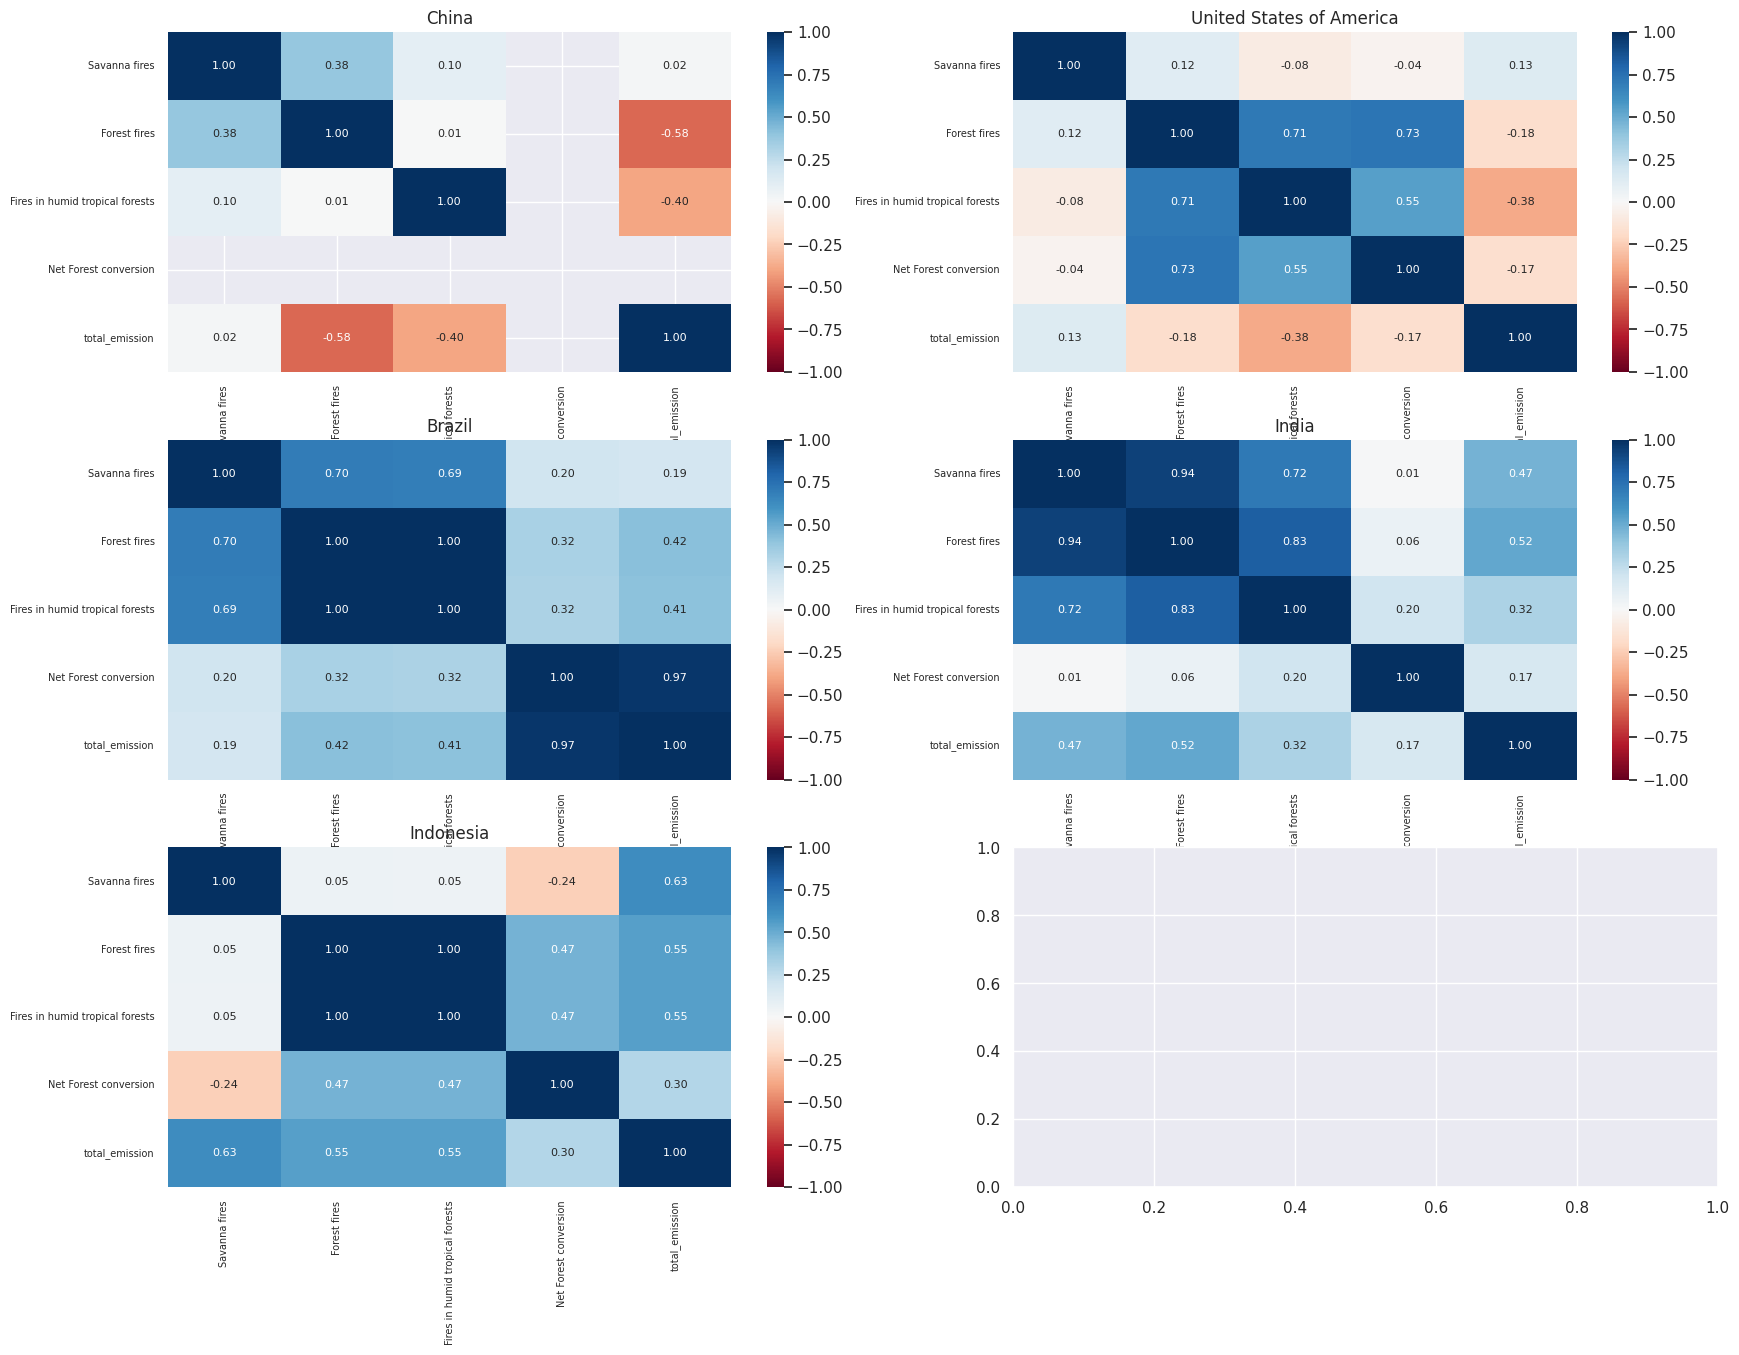

()

In [142]:
grafico_heatmap(df,incendios + ['Net Forest conversion'],maiores_produtores)

# Primeiro Grupo  (Correlação) - Analise dos Gráficos


    (1) No que diz respeito, ao que o autor deste estudo convenciou como práticas de cultivo, as "práticas" - no caso para o Brasil - apresentam um correlacionamento negativo com a emissão de CO2. Uma possível explicação seja que exista um aproveitamento melhor dos resíduos por parte das unidades produtoras (Fazendas) no Brasil.
    (2)Ainda dentro das práticas, para 4 dos 5 maiores produtores) não existe dados da emissão de CO2 decorrente da prática de utilizar fogo,algo de um certa forma surpreendente visto que no caso do Brasil há esta prática. Indonésia existe dado, é se observa um grande correlação com a emissão de CO2 do pais.
    (3) Com relação a incêndios nos Biomas, e desmatamento,
        (i) O destaque fica para o Brasil com o desmatamento correlacionando expressivamente para as emissões de CO2.
        (ii) Todos os paises há uma contribuição considerável dos incêndios na emissão de CO2
        (iii) Destaque para a falta de dados de emissões relacionadas com o desmatamento para a China
  

# Segunda Análise - Correlação

O segundo conjunto de análises  teve como objetivo verificar possíveis correlacionamento entre as emissões dos principais países produtores e as categorias de alimentos produzidos

    (1) Novamente se observa um correlação negativa no caso do Brasil, e do outro lado um correlação positiva entre as produções de alimentos da China e India com as emissões
    (2) Um ponto que chama atenção, para o autor em especial, é a correlação com as culturas categorizadas como Vegetais  




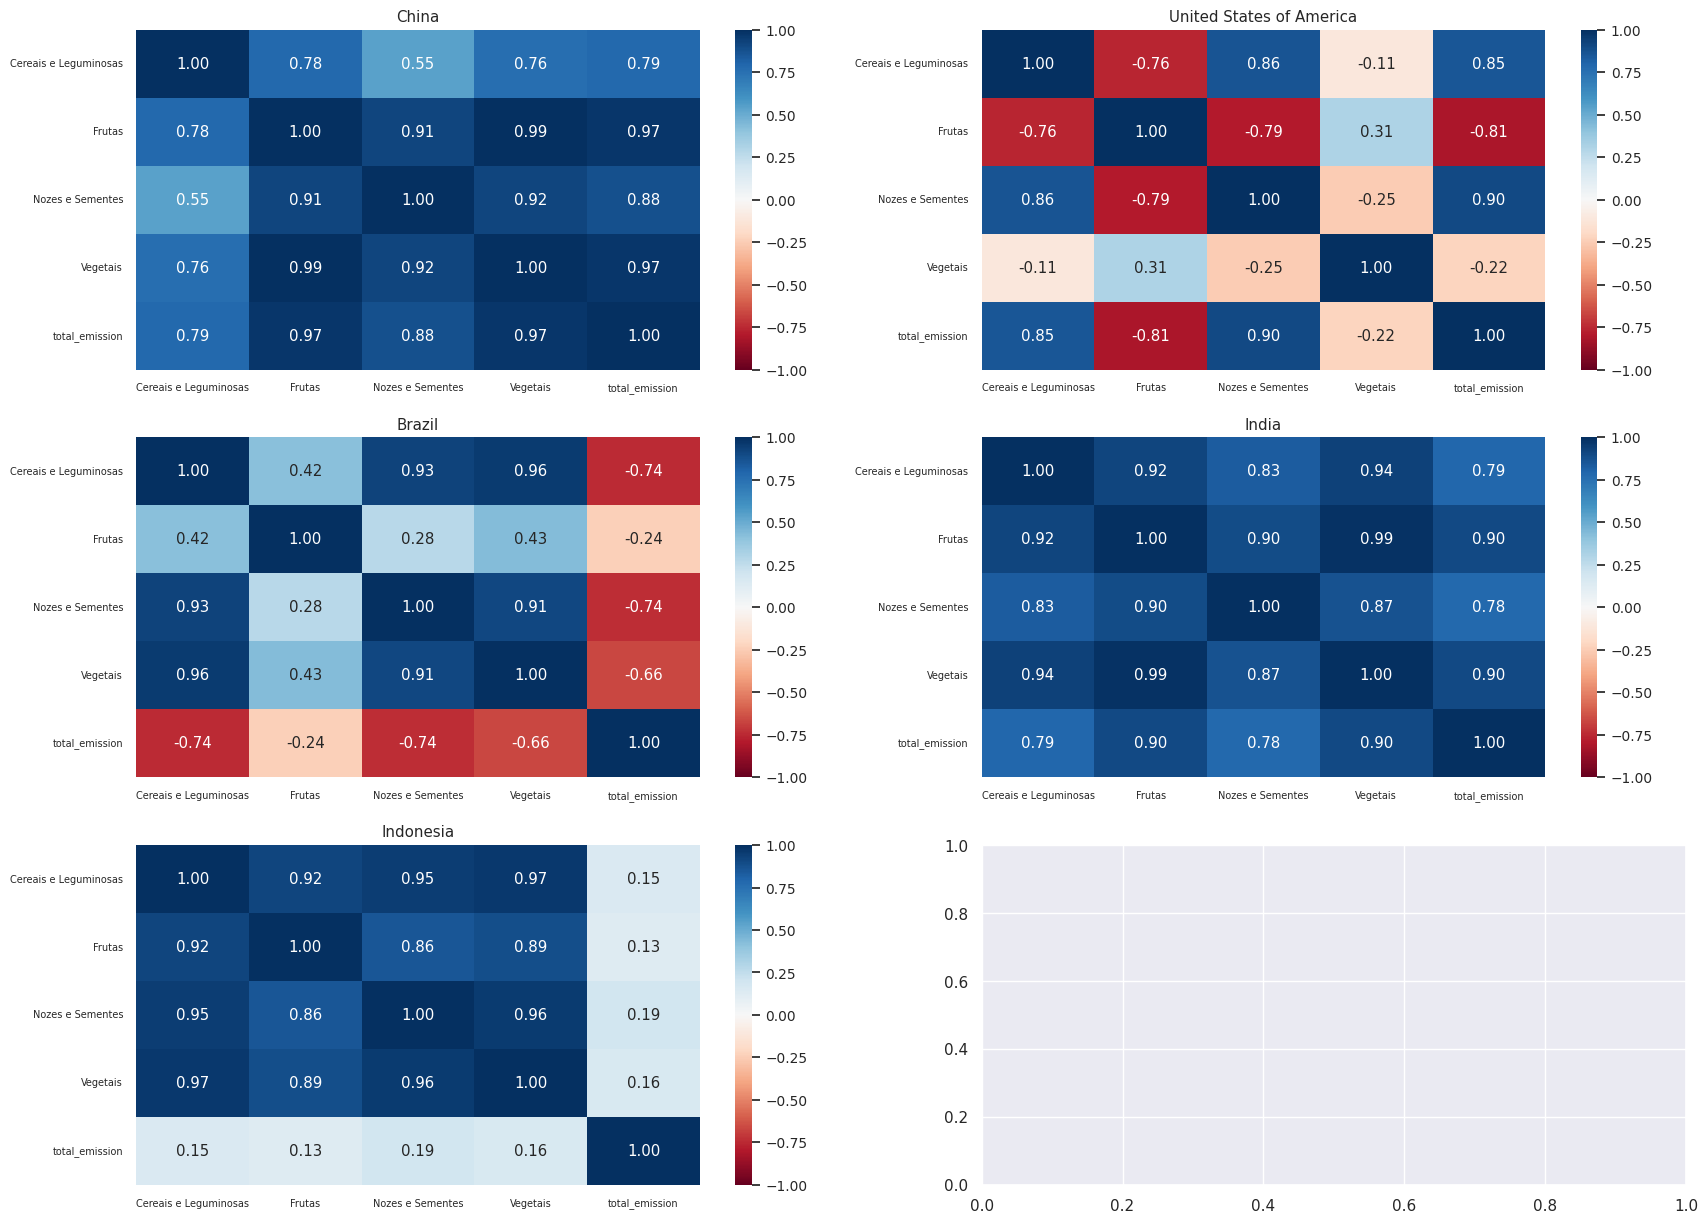

In [143]:
fig, ax = plt.subplots(3,2, figsize = (20, 15))
sns.set(font_scale=0.9)
i=j=0
for pais in maiores_produtores:
  sns.heatmap(df[df.Area == pais].loc[:,['Cereais e Leguminosas', 'Frutas', 'Nozes e Sementes', 'Vegetais','total_emission']].corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1,fmt="1.2f",ax=ax[i,j])
  ax[i,j].set_title(pais)
  ax[i,j].tick_params(axis='both', which='major', labelsize=7)
  j+=1
  if j == 2:
    i+=1
    j=0
plt.show()

# Análise de Clusters

O objetivo será identificar conjuntos de países que apresentam similaridades com relação as emissões de CO2 X Produção de Alimentos

Seleção dos Atributos

    (1) Os atributos 'Savanna fires', 'Forest fires','Fires in humid tropical forests' não são  considerados na Análise de Cluster. Os mesmos foram combinados para criação do 'soma_emissao_co2_incendio';
    (2) Da mesma forma os atributos abaixo também não são considerados
          (i) 'Crop Residues','Drained organic soils (CO2)','Agrifood Systems Waste Disposal', 'Fires in organic soils','Manure applied to Soils' foram removidos da análise (os mesmos foram combinados em 'soma_emissao_co2_cultivo';
          (ii) Os atributos 'Food Packaging' e 'Forest fires' foram combinados no soma_emissao_co2_cadeia_processamento'

In [144]:
df_sc.shape

(195, 17)

<ipython-input-145-1d31fca27e5d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018['Net Forest conversion']=df_2018['Net Forest conversion'].fillna(0)


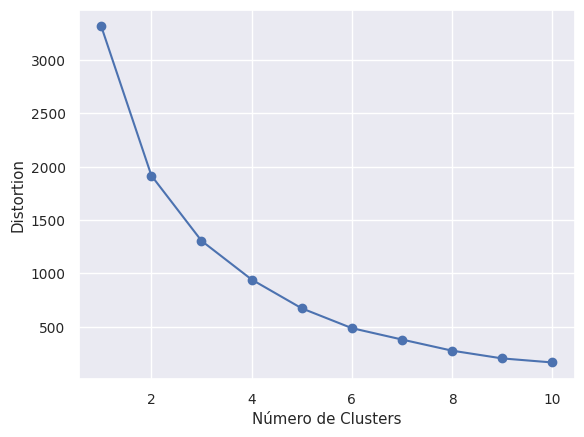

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [145]:
df_2018=df[df['Year']==2018]
df_2018['Net Forest conversion']=df_2018['Net Forest conversion'].fillna(0)

df_2018=df_2018.dropna(axis=1)

df_clus=df_2018.drop(['Area','Year','Urban population', 'Total Population - Male','Total Population - Female',
                      'Total','Savanna fires', 'Forest fires','Average Temperature °C', 'Food Packaging','Fires in humid tropical forests',
                      'Food Processing','Agrifood Systems Waste Disposal','Pesticides Manufacturing','Fertilizers Manufacturing'],axis=1)

sc = StandardScaler()

df_sc = sc.fit_transform(df_clus)

df_sc = pd.DataFrame(df_sc, columns=df_clus.columns)

distortions = []

for i  in range(1,11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(df_sc)
    distortions.append(km.inertia_)

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Distortion')
plt.show()


# selecionado 10 clusters

model = KMeans(n_clusters=4, random_state=1)
model.fit(df_sc)
cluster = model.labels_
df_clus['Area']=df_2018['Area']
df_clus['Cluster']=cluster
clus_col=df_clus.columns


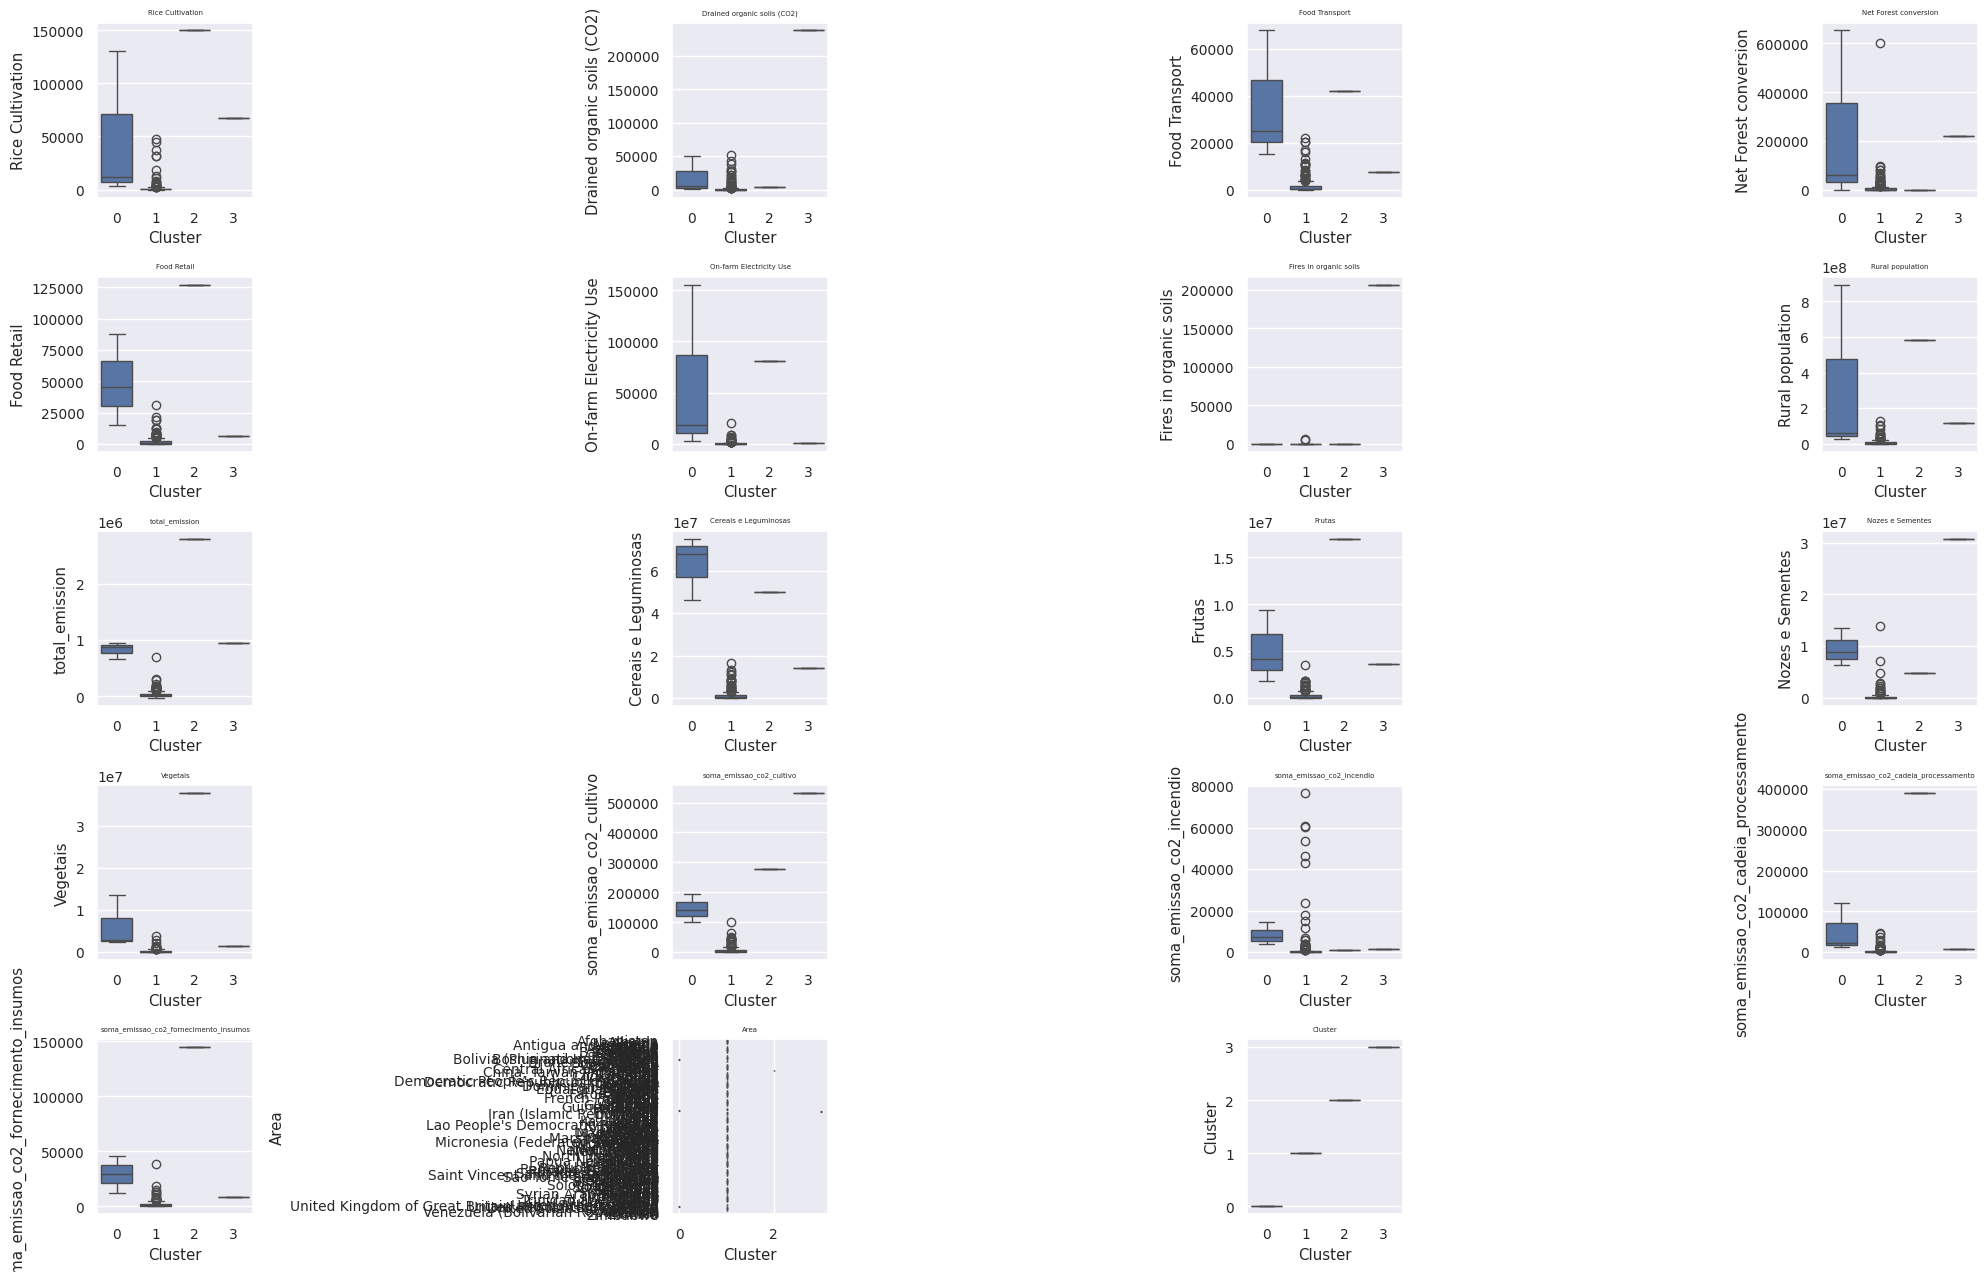

In [146]:
fig = plt.figure(figsize=(20,20))

for i in range(len(clus_col)):
    plt.subplot(8,4,i+1)
    sns.boxplot(df_clus,y=df_clus[clus_col[i]],x=df_clus['Cluster'])
    plt.title(clus_col[i],fontsize=5)

plt.tight_layout()
plt.show()

In [147]:
df_clus[df_clus.Area.isin(maiores_produtores)].loc[:,['Cluster','Area','total_emission','Frutas','Nozes e Sementes',
                                                      'Vegetais','Cereais e Leguminosas']].applymap(lambda x: '{:,.2f}'.format(x) if isinstance(x, float) else x)

<ipython-input-147-c67c62ddd5a7>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  'Vegetais','Cereais e Leguminosas']].applymap(lambda x: '{:,.2f}'.format(x) if isinstance(x, float) else x)


,Cluster,Area,total_emission,Frutas,Nozes e Sementes,Vegetais,Cereais e Leguminosas
574,0,Brazil,"668,703.96","4,136,173.42","8,887,200.31","2,482,146.50","75,035,360.16"
874,2,China,"2,802,407.47","16,983,130.29","4,807,407.74","37,839,044.33","49,805,078.51"
2012,0,India,"872,783.04","9,405,595.65","6,299,097.36","13,481,379.84","67,931,105.42"
2037,3,Indonesia,"952,997.84","3,634,683.50","30,719,493.05","1,404,824.25","13,890,978.91"
4664,0,United States of America,"946,132.46","1,794,190.43","13,588,107.76","2,811,628.19","46,231,245.68"


In [148]:
print('\n\n\n', 'VISÃO GERAL DOS CLUSTERS E MÉDIA DA EMISSA TOTAL E DA PRODUÇÃO DE ALIMENTOS','\n\n\n',df_clus.groupby('Cluster')[['total_emission','Cereais e Leguminosas', 'Frutas', 'Nozes e Sementes', 'Vegetais']].mean().sort_values(by='total_emission', ascending=False))





 VISÃO GERAL DOS CLUSTERS E MÉDIA DA EMISSA TOTAL E DA PRODUÇÃO DE ALIMENTOS 


          total_emission  Cereais e Leguminosas        Frutas  \
Cluster                                                        
2          2.802407e+06           4.980508e+07  1.698313e+07   
3          9.529978e+05           1.389098e+07  3.634684e+06   
0          8.292065e+05           6.306590e+07  5.111987e+06   
1          3.977390e+04           1.360404e+06  2.804521e+05   

         Nozes e Sementes      Vegetais  
Cluster                                  
2            4.807408e+06  3.783904e+07  
3            3.071949e+07  1.404824e+06  
0            9.591468e+06  6.258385e+06  
1            3.596206e+05  2.415703e+05  


<Axes: xlabel='Cluster', ylabel='total_emission'>

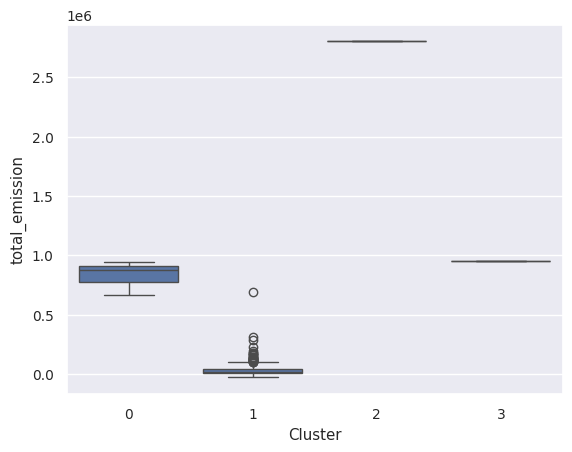

In [149]:
sns.boxplot(x='Cluster',y='total_emission',data=df_clus)


In [150]:
from IPython.display import display

print('\n\n\n', 'VISÃO GERAL DOS CLUSTERS E MÉDIA DA EMISSA TOTAL E DA PRODUÇÃO DE ALIMENTOS','\n\n\n')

# Calculate the mean values and sort
mean_values = df_clus.groupby('Cluster')[['total_emission','Cereais e Leguminosas', 'Frutas', 'Nozes e Sementes', 'Vegetais']].mean().sort_values(by='total_emission', ascending=False)

# Format numbers without scientific notation
mean_values = mean_values.applymap(lambda x: '{:.2f}'.format(x) if isinstance(x, (int, float)) else x)

# Display the result in a tabular format
display(mean_values.style.set_table_styles([{'selector': 'th', 'props': [('border', '1px solid black')]}])\
        .set_properties(**{'border': '1px solid black'}))




 VISÃO GERAL DOS CLUSTERS E MÉDIA DA EMISSA TOTAL E DA PRODUÇÃO DE ALIMENTOS 





<ipython-input-150-af93945c4466>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mean_values = mean_values.applymap(lambda x: '{:.2f}'.format(x) if isinstance(x, (int, float)) else x)


,total_emission,Cereais e Leguminosas,Frutas,Nozes e Sementes,Vegetais
Cluster,,,,,
2,2802407.47,49805078.51,16983130.29,4807407.74,37839044.33
3,952997.84,13890978.91,3634683.50,30719493.05,1404824.25
0,829206.49,63065903.75,5111986.50,9591468.48,6258384.84
1,39773.90,1360403.68,280452.06,359620.63,241570.25


NameError: name 'clus_col2' is not defined

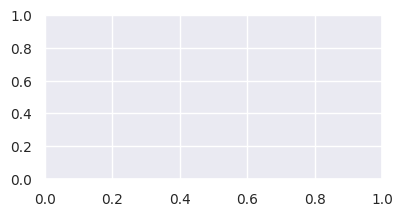

In [151]:
fig = plt.figure(figsize=(20,20))

for i in range(4):
    plt.subplot(8,4,i+1)
    sns.scatterplot(df_clus,x=df_clus[clus_col2[i]],y=df_clus['total_emission'],hue=df_clus['Cluster'],palette="Pastel1")
    plt.title(clus_col2[i],fontsize=5)

plt.tight_layout()
plt.show()